In [47]:
from elasticsearch import Elasticsearch
from deepface import DeepFace
import matplotlib.pyplot as plt
from retinaface import RetinaFace
import os
import time
import glob

In [48]:
es = Elasticsearch(hosts=['http://localhost:9200'], http_auth=('elastic', 'DkIed99SCb'))

In [49]:
model_name = 'ArcFace'
target_size = (160, 160)
embedding_size = 512

In [51]:
mapping = {
    "mappings": {
        "properties": {
            "title_vector":{
                "type": "dense_vector",
                "dims": embedding_size
            },
            "title_name": {"type": "keyword"}
        }
    }
}
   
es.indices.create(index="mpsdb", body=mapping)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'mpsdb'}

In [7]:
import csv
files = []

with open('mps.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        print(row['name'], row['party'])
        files.append(row)


মোঃ নূরুল ইসলাম সুজন বাংলাদেশ আওয়ামী লীগ
রমেশ চন্দ্র সেন বাংলাদেশ আওয়ামী লীগ
ড. শিরীন শারমিন চৌধুরী বাংলাদেশ আওয়ামী লীগ
আসাদুজ্জামান নূর বাংলাদেশ আওয়ামী লীগ
আনিসুল হক বাংলাদেশ আওয়ামী লীগ
সালমান এফ রহমান বাংলাদেশ আওয়ামী লীগ
খালিদ মাহ্‌মুদ চৌধুরী বাংলাদেশ আওয়ামী লীগ
মোঃ আফতাব উদ্দিন সরকার বাংলাদেশ আওয়ামী লীগ
টিপু মুনশি বাংলাদেশ আওয়ামী লীগ
মোঃ আছলাম হোসেন সওদাগর বাংলাদেশ আওয়ামী লীগ


In [14]:
import requests

for row in files:
    fname = row['photo'].rsplit('/', 1)[-1]
    print('downloading', fname, row['photo'])
    img_data = requests.get(row['photo']).content
    with open('dataset/mps/'+row['name']+'.jpg', 'wb') as handler:
        handler.write(img_data)

downloading 011000201.jpg https://web.archive.org/web/20240104194154im_/https://www.parliament.gov.bd/mps/011000201.jpg
downloading 011000301.jpg https://web.archive.org/web/20240104194355im_/https://www.parliament.gov.bd/mps/011000301.jpg
downloading 011002401.jpg https://web.archive.org/web/20240104194355im_/https://www.parliament.gov.bd/mps/011002401.jpg
downloading 011001301.jpg https://web.archive.org/web/20240104194355im_/https://www.parliament.gov.bd/mps/011001301.jpg
downloading prothomalo-bangla%2F2021-12%2F360d7e8a-d495-404c-9d04-2965a0b5d4ef%2Flaw_minister_anisul_haque.jpeg?rect=0%2C0%2C725%2C483&auto=format%2Ccompress&fmt=webp&format=webp&w=640&dpr=1.0 https://images.prothomalo.com/prothomalo-bangla%2F2021-12%2F360d7e8a-d495-404c-9d04-2965a0b5d4ef%2Flaw_minister_anisul_haque.jpeg?rect=0%2C0%2C725%2C483&auto=format%2Ccompress&fmt=webp&format=webp&w=640&dpr=1.0
downloading salman-f-rahman-06_1.jpg https://www.thedailystar.net/sites/default/files/images/2022/08/31/salman-f-rah

In [52]:
dir_path = "dataset/mps/*.*"
res = glob.glob(dir_path, recursive=True)
files = []
for item in res:
    if item.endswith('.jpg'):
        files.append(item)
print('total files:', len(files))

total files: 10


In [53]:
index = 0
tic = time.time()

for img_path in files:
    print('indexing', img_path)
    try:
        embedding_objs = DeepFace.represent(img_path=img_path, 
            model_name = model_name,
            detector_backend = 'retinaface'
        )
        embedding = embedding_objs[0]["embedding"]
        doc = {"title_vector": embedding, "title_name": img_path}
        es.create("mpsdb", id=index, body=doc)
    except:
        pass

    index = index + 1
toc = time.time()
print("indexing completed in ",toc-tic," seconds")

indexing dataset/mps/km-chowdhury.jpg
indexing dataset/mps/aftab.jpg
indexing dataset/mps/tipu.jpg
indexing dataset/mps/sujon.jpg
indexing dataset/mps/shireen.jpg
indexing dataset/mps/aslam.jpg
indexing dataset/mps/anisul.jpg
indexing dataset/mps/sfrahman.jpg
indexing dataset/mps/ramesh.jpg
indexing dataset/mps/asad.jpg
indexing completed in  12.261807918548584  seconds


In [90]:
target_img_path = "dataset/targets/7.jpeg"
embedding_objs = DeepFace.represent(img_path = target_img_path, 
  model_name = model_name,
  detector_backend = 'retinaface'
)
target_embedding = embedding_objs[0]["embedding"]

In [94]:
query = {
    "size": 1,
    "query": {
    "script_score": {
        "query": {
            "match_all": {}
        },
        "script": {
            #"source": "cosineSimilarity(params.queryVector, 'title_vector') + 1.0",
            "source": "1 / (1 + l2norm(params.queryVector, 'title_vector'))", #euclidean distance
            "params": {
                "queryVector": list(target_embedding)
            }
        }
    }
}}

In [95]:
tic = time.time()
res = es.search(index="mpsdb", body=query)
toc = time.time()

print(toc-tic," seconds")

0.05278801918029785  seconds


dataset/mps/sfrahman.jpg . Score:  0.20811026


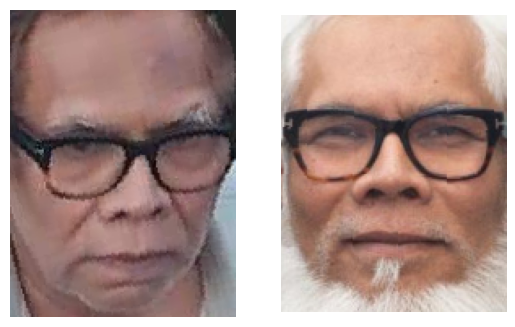

-------------------------


In [96]:
target_faces = RetinaFace.extract_faces(img_path = target_img_path, align = True)
target_img = target_faces[0]

for i in res["hits"]["hits"]:
    candidate_name = i["_source"]["title_name"]
    candidate_score = i["_score"]
    print(candidate_name, ". Score: ", candidate_score)
    candidate_faces = RetinaFace.extract_faces(img_path = candidate_name, align = True)
    candidate_img = candidate_faces[0]

    fig = plt.figure()

    ax1 = fig.add_subplot(1, 2, 1)
    plt.imshow(target_img)
    plt.axis('off')

    ax2 = fig.add_subplot(1, 2, 2)
    plt.imshow(candidate_img)
    plt.axis('off')

    plt.show()

    print("-------------------------")